## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.






In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
from sklearn.metrics import accuracy_score
import typing
%matplotlib inline

torch.manual_seed(0)

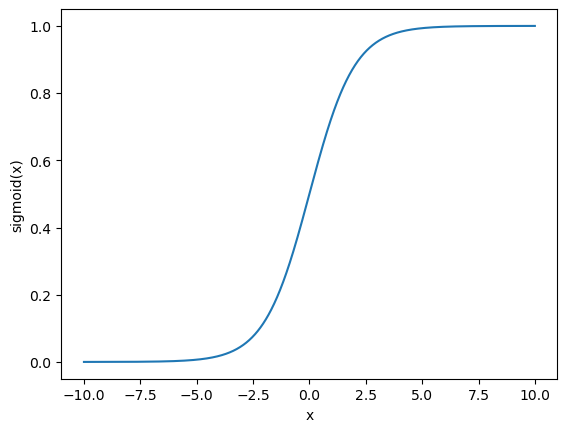

In [2]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
    # z = 1/(1 + torch.exp(-x))
    return 1/(1 + torch.exp(-z))


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [3]:
## logistic regression class
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1, num_features), requires_grad=False)
    
  def forward(self, x):
    y = 0
    a =  torch.matmul(x,self.weight.t())
    
    y = 1/(1+torch.exp(-a))
    return y
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  ### your code here
  J = sum((-y_true*(torch.log(y_pred)))-((1-y_true)*(torch.log(1-y_pred))))/len(y_pred)
  return J

# 1. The XOR problem


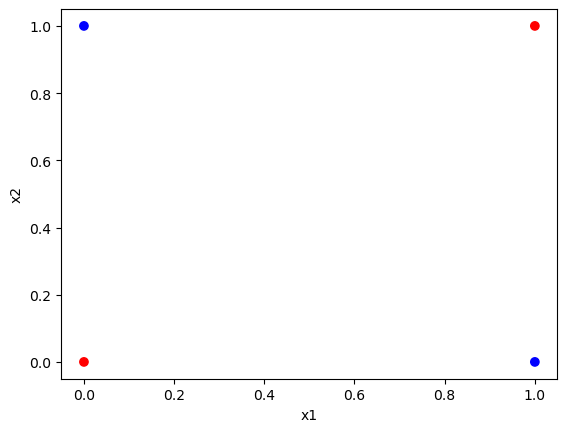

In [4]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

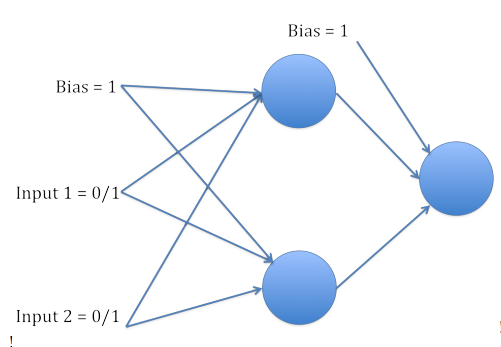

Using `LogisticRegression` and `sigmoid` , implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://colab.research.google.com/drive/1Fnl8Li2zgWgEHDTlR9jVtgSBXdg3Fs4S#scrollTo=_dF-9HU4jUWI&line=6&uniqifier=1).

In [5]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs):
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias
   
  def forward(self, x: torch.tensor) -> torch.tensor:
    y_hidden = torch.ones(len(self.hidden_layer) + 1) # +1 for the bias
    y_output = torch.ones(len(self.output_layer))
    ### your code here
    
    for i in range(len(self.hidden_layer)):
        
        hidden_layer =  self.hidden_layer[i](x)
        y_hidden[i] = hidden_layer
        
    for j in range(len(self.output_layer)):
        output_layer = self.output_layer[j](y_hidden)
        y_output[j] = output_layer
    return y_output
  
  def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
    ### your code here
    y_hidden = torch.ones(len(self.hidden_layer) + 1)
    y_output = torch.ones(len(self.output_layer))
    delta_hidden_error =[]
    output_layer_weights =[]
    for i in range(len(self.hidden_layer)):
        
        hidden_layer =  self.hidden_layer[i](x)
        y_hidden[i] = hidden_layer
    # print(y_hidden,'new y_hidden')    
    for j in range(len(self.output_layer)):
        output_layer = self.output_layer[j](y_hidden)
        y_output[j] = output_layer
    
    delta_output_error = (y_output-y) *(y_output*(1-y_output))
    # print(delta_output_error)
    # print(self.hidden_layer[0].weight)
    # for k in range  (len(self.hidden_layer)):
        
    a = (y_hidden[:-1])*(1 - y_hidden[:-1])*(self.output_layer[0].weight[0][:-1]*delta_output_error)
       
    delta_hidden_error.append(a)
    # print(delta_hidden_error)
    
    for l in range(len(self.output_layer)):
        self.output_layer[l].weight[0] = self.output_layer[l].weight[0] -(lr*delta_output_error[l]*y_hidden[l])
    
    # print(x)
    for m in range(len(self.hidden_layer)):
        # print(delta_hidden_error[0][m])
        self.hidden_layer[m].weight[0] -= delta_hidden_error[0][m]*x *lr
        

    return

In [6]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([0.7854])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0): LogisticRegression()
    (1): LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[0.4963, 0.7682, 0.0885]])
hidden_layer.1.weight Parameter containing:
tensor([[0.1320, 0.3074, 0.6341]])
output_layer.0.weight Parameter containing:
tensor([[0.4901, 0.8964, 0.4556]])

Hidden layer weight matrix:
tensor([[[0.4963, 0.7682, 0.0885]],

        [[0.1320, 0.3074, 0.6341]]])


In the `NeuralNetwork` class above, fill in the `backward_pass()` method. 

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to probagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $a_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [7]:
# test it works
model.backward_pass(x_test, y_test, 1)

+Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

In [8]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  ### your code here
    J = sum((-y_true*(torch.log(y_pred)))-((1-y_true)*(torch.log(1-y_pred))))/len(y_pred)
    return J

torch.Size([4, 3])


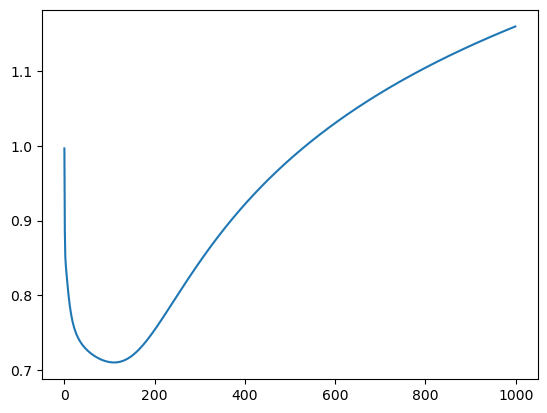

tensor([0., 1., 1., 0.]) tensor([0.0476, 0.1068, 0.1068, 0.0000])


In [9]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])

lr = 3
iterations = 1000
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

errors = list()
for ep in range(iterations):
  error = 0
  for i in range(x.shape[0]):
    y_pred = model(x[i])
    error += bce(y[i], y_pred)
    model.backward_pass(x[i], y[i], lr)
  errors.append(error/x.shape[0])
plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[1]):
  y_pred[i] = model(x[i])
print(y, y_pred)


# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [10]:
iris = datasets.load_iris(as_frame=True)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [11]:
# ### your code here
# # iris
# #Taken from week 4 Classification lab
# # iris_db = datasets.load_iris(as_frame=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = F.one_hot(y_train.reshape(-1).long(),num_classes = 3)

y_test = torch.from_numpy(y_test.values).int()
y_test = F.one_hot(y_test.reshape(-1).long(),num_classes = 3)

mu_mean = []
sigma_std = []
for k in range(4):
    mu_mean.append(torch.mean(x_train[:,k]))
    sigma_std.append(torch.std(x_train[:,k]))

def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  

    for i in range(0,4):
        
        x[:,i] = (x[:,i]- mu[i])/sigma[i]
    return x


x_train = norm_set(x_train, mu_mean,sigma_std )
# print('Train\n',x_train)
x_test = norm_set(x_test,mu_mean,sigma_std)
# print('Test\n',x_test)


Accuarcy is 33.33333333333333 %   



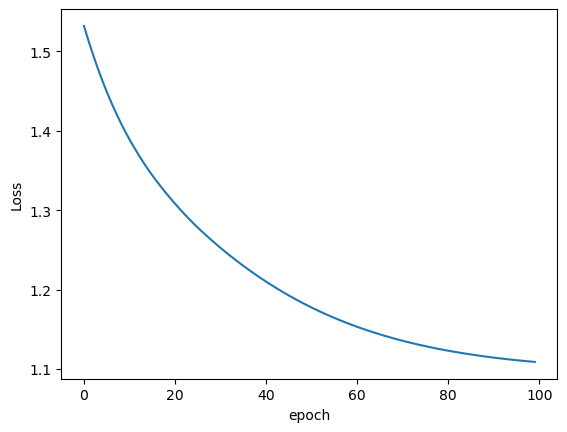

In [12]:
# ### your code here
class Model(nn.Module):
    # Defining my neural network based on input features and hidden layer ( I keep on changing that to get the results like 1,2,4,8,16,32)
    def __init__(self, input_features=4, hidden_layer1=1, output_features=3):
        super().__init__()
        self.input_features = input_features
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.out = nn.Linear(hidden_layer1, output_features)      
    # implementing forward propogation    
    def forward(self, x):
        x = x.view(-1,self.input_features)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
# model initialized    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# running for a 100 epchs 
epochs = 100
losses = []
# running for loop for 100 epochs 
for i in range(epochs):
    y_pred = model.forward(x_train)
    y_train = y_train.to(torch.float32)
    loss = criterion(y_pred, y_train)
    losses.append(float(loss))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');
# storing the values for predcition and true 
predicted_value = []
true =[]
with torch.no_grad():
    for i in x_test:
        y_model = model.forward(i)
        predicted_value.append(y_model.argmax().item())

for i in range(len(y_test)):
    true.append(torch.argmax(y_test[i]))

accuracy = accuracy_score(predicted_value,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')


Accuarcy is 93.33333333333333 %   



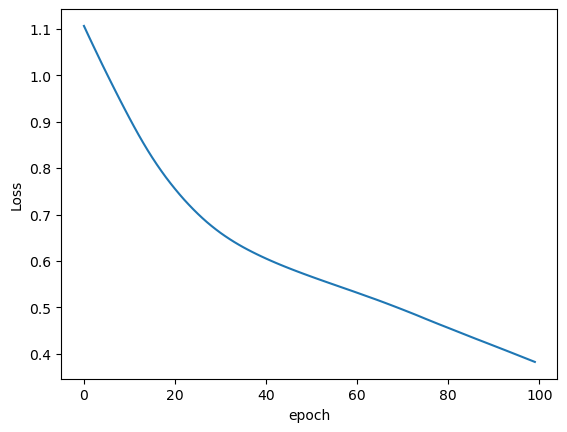

In [13]:
# ### your code here
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=2, output_features=3):
        super().__init__()
        self.input_features = input_features
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.out = nn.Linear(hidden_layer1, output_features)      
        
    def forward(self, x):
        x = x.view(-1,self.input_features)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)
    y_train = y_train.to(torch.float32)
    loss = criterion(y_pred, y_train)
    losses.append(float(loss))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

predicted_value = []
true =[]
with torch.no_grad():
    for i in x_test:
        y_model = model.forward(i)
        predicted_value.append(y_model.argmax().item())

for j in range(len(y_test)):
    true.append(torch.argmax(y_test[j]))

accuracy = accuracy_score(predicted_value,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')


Accuarcy is 96.66666666666667 %   



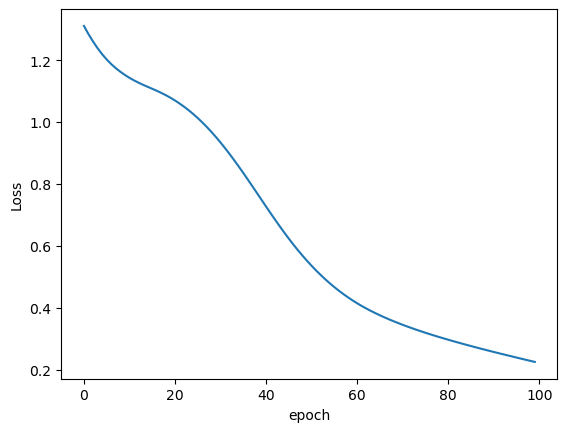

In [14]:
# ### your code here
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=4, output_features=3):
        super().__init__()
        self.input_features = input_features
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.out = nn.Linear(hidden_layer1, output_features)      
        
    def forward(self, x):
        x = x.view(-1,self.input_features)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)
    y_train = y_train.to(torch.float32)
    loss = criterion(y_pred, y_train)
    losses.append(float(loss))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

predicted_value = []
true =[]
with torch.no_grad():
    for i in x_test:
        y_model = model.forward(i)
        predicted_value.append(y_model.argmax().item())

for i in range(len(y_test)):
    true.append(torch.argmax(y_test[i]))

accuracy = accuracy_score(predicted_value,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')


Accuarcy is 96.66666666666667 %   



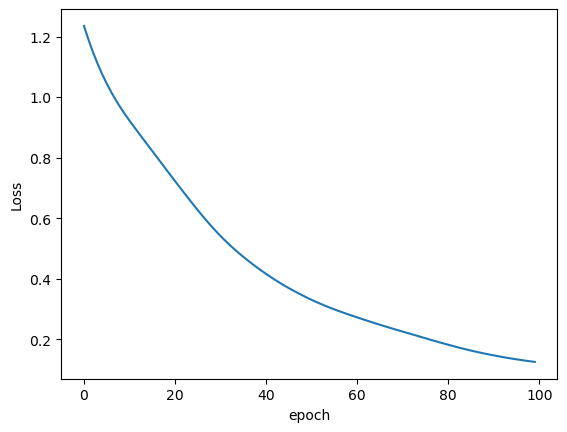

In [15]:
# ### your code here
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=8, output_features=3):
        super().__init__()
        self.input_features = input_features
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.out = nn.Linear(hidden_layer1, output_features)      
        
    def forward(self, x):
        x = x.view(-1,self.input_features)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)
    y_train = y_train.to(torch.float32)
    loss = criterion(y_pred, y_train)
    losses.append(float(loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

predicted_value = []
true =[]
with torch.no_grad():
    for i in x_test:
        y_model = model.forward(i)
        predicted_value.append(y_model.argmax().item())

for i in range(len(y_test)):
    true.append(torch.argmax(y_test[i]))

accuracy = accuracy_score(predicted_value,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')


Accuarcy is 100.0 %   



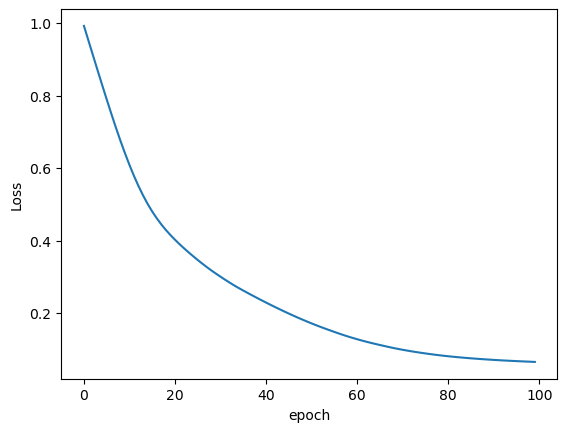

In [16]:
# ### your code here
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=16, output_features=3):
        super().__init__()
        self.input_features = input_features
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.out = nn.Linear(hidden_layer1, output_features)      
        
    def forward(self, x):
        x = x.view(-1,self.input_features)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)
    y_train = y_train.to(torch.float32)
    loss = criterion(y_pred, y_train)
    losses.append(float(loss))
    # p
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

predicted_value = []
true =[]
with torch.no_grad():
    for i in x_test:
        y_model = model.forward(i)
        predicted_value.append(y_model.argmax().item())
#
for i in range(len(y_test)):
    true.append(torch.argmax(y_test[i]))

accuracy = accuracy_score(predicted_value,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')


Accuarcy is 100.0 %   



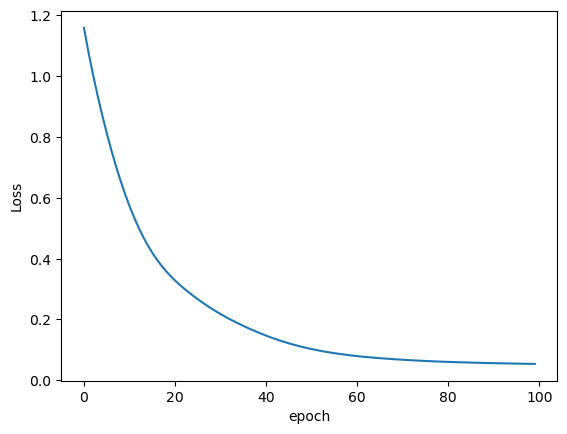

In [17]:
# ### your code here
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=32, output_features=3):
        super().__init__()
        self.input_features = input_features
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.out = nn.Linear(hidden_layer1, output_features)      
        
    def forward(self, x):
        x = x.view(-1,self.input_features)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)
    y_train = y_train.to(torch.float32)
    loss = criterion(y_pred, y_train)
    losses.append(float(loss))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

predicted_value = []
true =[]
with torch.no_grad():
    for i in x_test:
        y_model = model.forward(i)
        predicted_value.append(y_model.argmax().item())

for i in range(len(y_test)):
    true.append(torch.argmax(y_test[i]))

accuracy = accuracy_score(predicted_value,true)
print('\nAccuarcy is {} %  '.format(accuracy*100),'\n')